# Picocoder
_A Raspberry Pi Pico microcode glitcher_

## Connection
We connect with the Pi Pico and setup some glitching options.

In [1]:
%matplotlib widget

POWERSUPPLY_PORT = '/dev/ttyACM0'
GLITCHER_PORT = '/dev/ttyACM1'
GLITCHER_BAUD = 115200

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from importlib import reload # for debugging

import glitch_utils
from glitch_utils import Picocoder, GlitchResult
from power_supply import PowerSupply, KA3305P
glitch_utils = reload(glitch_utils)

try:
	del ps
	del glitcher
	del gc
except:
	pass
ps = KA3305P(port=POWERSUPPLY_PORT, cycle_wait=0.5)
ps.con()
ps.power_cycle()

glitcher = glitch_utils.Picocoder(GLITCHER_PORT, GLITCHER_BAUD)
if not glitcher.ping():
	raise Exception("Glitcher not responding")
if not glitcher.ping_target():
	raise Exception("Target not responding")

def reset_target(ps: PowerSupply, glitcher: Picocoder) -> None:
	ps.power_cycle()
	if not glitcher.ping_target():
		raise Exception("Target not responding after reset")

## Measure the duration of opcode loop
We obtain an estimate (in us) of the loop where the opcode is executed, which
is an upper bound for ext_offset+width.

This is calculated by measuring the number of microseconds between two
consecutive bytes received by the glitcher from the t arget, and subtracting
the time between the first UART pulse appears on the channel, and when the
glitcher detects an incoming byte. It is therefore expected to be less than
the actual duration of the opcode loop.

In [2]:
max_total_duration = glitcher.measure_loop_duration()
if max_total_duration < 0:
	raise Exception(f'Invalid duration {max_total_duration}')
print(f"Measured total duration: {max_total_duration}")

Measured total duration: 269


## Measure UART delay
This command is used to measure (externally) the time it takes for the Pico to
detect data on the UART RX pin and to start processing it. <br>
The debug pin (GPIO 16, shown blue) is toggled when the Pico detects data.

![Oscilloscope capture](../firmware/inject_v2/img/fast_response_time_busy_wait_on_UART_with_timeout.png)

In [3]:
glitcher.uart_toggle_debug_pin()

## Voltage range

### TODO change this part
Find where the CPU starts to stall. We ask the target to send 50 bytes to the
pico, and then we bring the voltage down for a fairly long time.

The target will then either behave normally or die altogether, not just stall
for some clock cycles. This test is fairly slow as it involves a lot of
external resets, but within a handful of minutes a sensible working voltage
can be identified right above the reset cluster

![Voltage range test plot (ignore the squares)](img/voltage_range_plot.png)

Here, for example, we can see that down to 59 (0b111011) the target is mostly
working, but there is a significant amount of crashed at 58 (0b111010). 59 will
then be the starting value for the glitching range.

### Oscilloscope captures
| Color | Description |
| --- | --- |
| Yellow | Target UART TX |
| Pink | PMBus/I2C SCL |
| Blue | PMBus/I2C SDA |
| Green | VCore |

#### No effect
When the voltage drop does not affect the target, it will successfully send the
50 bytes.

![Safe voltage and width](img/voltage_range_alive.png)

#### CPU halt
When the voltage is too low, the target will hang and not finish sending data.

![Too low voltage](img/voltage_range_dead.png)

In [ ]:
gc_vp = glitch_utils.GlitchController(groups=[r.name for r in GlitchResult], parameters=['ext_offset', 'prep_voltage'])
gc_vp.set_range('ext_offset', 477-200, 477-150) # old max_total_duration measured without nop loop
# gc_vp.set_range('prep_voltage', 0b0101001, 0b0110011) # 0.9V-1V - See Table 6-3 in TPS65094 datasheet
gc_vp.set_range('prep_voltage', 0b0011111, 0b0101001) # 0.8V-0.9V - See Table 6-3 in TPS65094 datasheet
# gc_vp.set_range('prep_voltage', 0b0011111, 0b0100011) # 0.8V-0.84V - See Table 6-3 in TPS65094 datasheet
# gc_vp.set_range('prep_voltage', 0b0010101, 0b0011111) # 0.7V-0.8V - See Table 6-3 in TPS65094 datasheet
glitcher.voltage = 0b0111101 # 1.1V

# NOTE This figure must be generated in a different cell than the one that calls the plot function
#	   Otherwise the plot will not be displayed until the cell is done executing (no live plot)
fig, ax = plt.subplots()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
for gs in gc_vp.rand_glitch_values():
	try:
		[max_ext_offset, prep_voltage] = gs
		# glitcher.voltage = prep_voltage # Use same as prep during "glitch"
		read_result, read_data = glitcher.mul_test_vp(gs)
		gc_vp.add_result(gs, read_result)
		if read_result == GlitchResult.SUCCESS:
			[successes, result_a, result_b] = read_data
			print(f'SUCCESS! With {successes} iterations, {result_a} != {result_b}')
		if read_result == GlitchResult.WEIRD:
			print(f'Got weird response: 0x{read_data.hex()}')
		if read_result == GlitchResult.HALF_SUCCESS:
			print(f'HALF SUCCESS! {read_data} != {read_data}')
			break # Stop here so we can see on the oscilloscope
		# Print current point
		ax.plot(max_ext_offset, prep_voltage, read_result)

		fig.canvas.draw() # Guarantees live update of the plot whenever a new point is added

		if read_result in [GlitchResult.RESET, GlitchResult.BROKEN]:
			reset_target(ps, glitcher)
	except KeyboardInterrupt:
		fig.canvas.draw()
		break # Gentle stop, otherwise the plot might look empty

## Estimate $V_p$

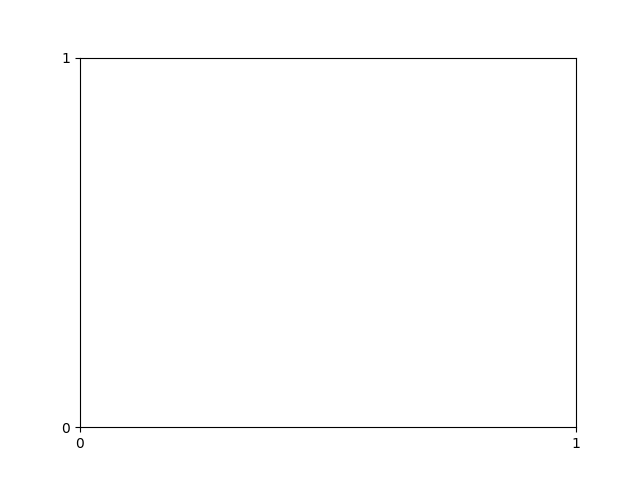

In [13]:
gc_vp = glitch_utils.GlitchControllerTPS65094(groups=[r.name for r in GlitchResult], parameters=['ext_offset', 'width', 'voltage', 'prep_voltage'], nominal_voltage=1.24) # Nominal voltage after boot completes
gc_vp.set_range('ext_offset', 90, 150) # 477-250, 477-200 working with muls
gc_vp.set_range('width', 61, 61)
gc_vp.set_range('prep_voltage', 0b0011010, 0b0101010) # 0.91V - See Table 6-3 in TPS65094 datasheet
gc_vp.set_range('voltage', 0b1000111, 0b1000111) # 1.2V - See Table 6-3 in TPS65094 datasheet

gc_vp.draw_graph('ext_offset', 'prep_voltage')

In [14]:
BREAK_ON_HALF_SUCCESS = False
BREAK_ON_SUCCESS = False
for gs in gc_vp.rand_glitch_values():
	try:

		read_result, read_data = glitcher.glitch_mul(gs)
		gc_vp.add_result(gs, read_result, read_data)

		if read_result == GlitchResult.WEIRD:
			print(f'Got weird response: 0x{read_data.hex()}')
		if read_result == GlitchResult.HALF_SUCCESS:
			# print(f'HALF SUCCESS!')
			# print(f'\tParameters: prep_voltage {glitcher.prep_voltage}, ext_offset {gs["ext_offset"]}, width {gs["width"]} and voltage {gs["voltage"]}')
			if BREAK_ON_HALF_SUCCESS:
				break # Stop before reset, so we can see on the oscilloscope
		if read_result == GlitchResult.SUCCESS:
			[successes, result_a, result_b] = read_data
			print(f'SUCCESS! With {successes} successful glitche(s), {result_a} != {result_b}')
			print(f'\tParameters: prep_voltage {glitcher.prep_voltage}, ext_offset {gs["ext_offset"]}, width {gs["width"]} and voltage {gs["voltage"]}')
			if BREAK_ON_SUCCESS:
				break

		if read_result in [GlitchResult.RESET, GlitchResult.BROKEN, GlitchResult.HALF_SUCCESS]:
			reset_target(ps, glitcher)
	except KeyboardInterrupt:
		gc_vp.redraw_graph()
		break # Gentle stop, otherwise the plot might look empty

## Glitch loop

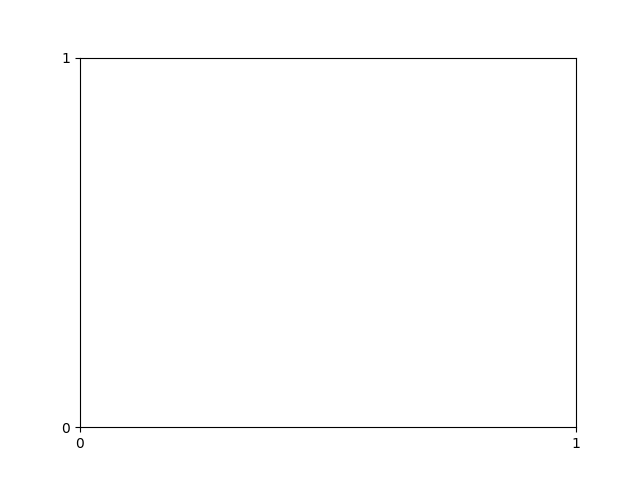

In [3]:
gc = glitch_utils.GlitchControllerTPS65094(groups=[r.name for r in GlitchResult], parameters=['ext_offset', 'width', 'voltage', 'prep_voltage'], nominal_voltage=1.24) # Nominal voltage after boot completes
gc.set_range('ext_offset', 10, 100) # 477-250, 477-200 working with muls
gc.set_range('width', 1, 100)
gc.set_range('voltage', 28, 34) # 0.79V-0.83V - See Table 6-3 in TPS65094 datasheet
gc.set_range('prep_voltage', 0b0101010, 0b0101010) # 0.91V - See Table 6-3 in TPS65094 datasheet

gc.draw_graph('width', 'voltage')

In [4]:
BREAK_ON_HALF_SUCCESS = False
BREAK_ON_SUCCESS = False
for gs in gc.rand_glitch_values():
	try:

		read_result, read_data = glitcher.glitch_mul(gs)
		gc.add_result(gs, read_result, read_data)

		if read_result == GlitchResult.WEIRD:
			print(f'Got weird response: 0x{read_data.hex()}')
		if read_result == GlitchResult.HALF_SUCCESS:
			# print(f'HALF SUCCESS!')
			# print(f'\tParameters: prep_voltage {glitcher.prep_voltage}, ext_offset {gs["ext_offset"]}, width {gs["width"]} and voltage {gs["voltage"]}')
			if BREAK_ON_HALF_SUCCESS:
				break # Stop before reset, so we can see on the oscilloscope
		if read_result == GlitchResult.SUCCESS:
			[successes, result_a, result_b] = read_data
			print(f'SUCCESS! With {successes} successful glitche(s), {result_a} != {result_b}')
			print(f'\tParameters: prep_voltage {glitcher.prep_voltage}, ext_offset {gs["ext_offset"]}, width {gs["width"]} and voltage {gs["voltage"]}')
			if BREAK_ON_SUCCESS:
				break

		if read_result in [GlitchResult.RESET, GlitchResult.BROKEN, GlitchResult.HALF_SUCCESS]:
			reset_target(ps, glitcher)
	except KeyboardInterrupt:
		gc.redraw_graph()
		break # Gentle stop, otherwise the plot might look empty

In [16]:
print('Total:', len(gc.results))
set([r for [_, r, _] in gc.results])

Total: 1546


{<GlitchResult.NORMAL: '1b'>,
 <GlitchResult.BROKEN: 'Xm'>,
 <GlitchResult.RESET: 'xr'>}

### Additional plots
Now we can plot another graph view to see if successful glitches are clustered
around a certain external offset and voltage.

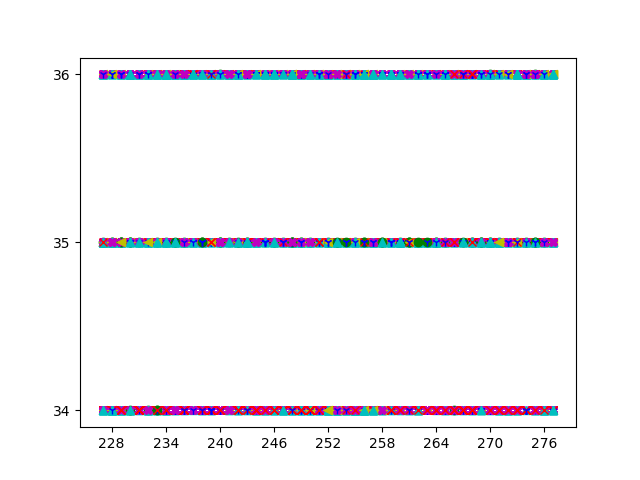

In [6]:
fig, ax = gc.draw_graph_view('ext_offset', 'voltage')

We can now separate the 3 VID levels we tested and see how the target behaves.
Here we plot all the glitches, clustering them in 3 main groups:
- green: normal operation
- yellow: reset, weird, half success and broken
- red: successful glitch

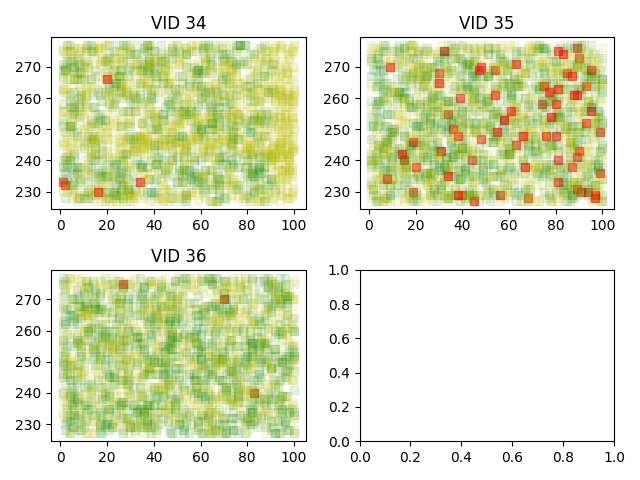

In [42]:
fig, ax = plt.subplots(ncols=2, nrows=2, layout="tight")
ax[0, 0].set_title('VID 34')
ax[0, 1].set_title('VID 35')
ax[1, 0].set_title('VID 36')

simplify_color = { # Go from 6 different markers/colors to 3 for better visibility once we have a lot of data
	GlitchResult.RESET					: 'sy', # Yellow
	GlitchResult.NORMAL					: 'sg', # Green
	GlitchResult.WEIRD					: 'sy', # Yellow
	GlitchResult.SUCCESS				: 'sr', # Red
	GlitchResult.HALF_SUCCESS			: 'sy', # Yellow
	GlitchResult.BROKEN					: 'sy', # Yellow
}

for glitch_values, result in gc.results:
	if glitch_values['voltage'] == 34:
		ax[0, 0].plot(glitch_values['width'], glitch_values['ext_offset'], simplify_color[result], alpha=0.1 if result != GlitchResult.SUCCESS else 0.5)
	if glitch_values['voltage'] == 35:
		ax[0, 1].plot(glitch_values['width'], glitch_values['ext_offset'], simplify_color[result], alpha=0.1 if result != GlitchResult.SUCCESS else 0.5)
	if glitch_values['voltage'] == 36:
		ax[1, 0].plot(glitch_values['width'], glitch_values['ext_offset'], simplify_color[result], alpha=0.1 if result != GlitchResult.SUCCESS else 0.5)

And here we only plot non-normal iterations, as we mostly care about where
abnormal behavior happens. We can see from both this and the previous graph
that we are interested in VID 35 and that we want to expand the width range
to the right.

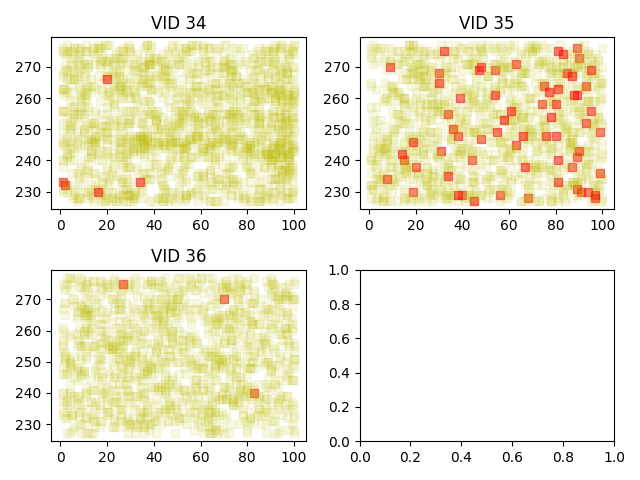

In [43]:
fig, ax = plt.subplots(ncols=2, nrows=2, layout="tight")
ax[0, 0].set_title('VID 34')
ax[0, 1].set_title('VID 35')
ax[1, 0].set_title('VID 36')

for glitch_values, result in gc.results:
	if result == GlitchResult.NORMAL:
		continue
	if glitch_values['voltage'] == 34:
		ax[0, 0].plot(glitch_values['width'], glitch_values['ext_offset'], simplify_color[result], alpha=0.1 if result != GlitchResult.SUCCESS else 0.5)
	if glitch_values['voltage'] == 35:
		ax[0, 1].plot(glitch_values['width'], glitch_values['ext_offset'], simplify_color[result], alpha=0.1 if result != GlitchResult.SUCCESS else 0.5)
	if glitch_values['voltage'] == 36:
		ax[1, 0].plot(glitch_values['width'], glitch_values['ext_offset'], simplify_color[result], alpha=0.1 if result != GlitchResult.SUCCESS else 0.5)